**NER (Named Entity Recognition)** - задача выделения сущностей из текста. Например, выделение Москвы как места, имен личностей и т.д.
Начнем с самого простого метода решения задачи.

**Rule-based approach** - подход, основанный на строгих предопределенных правилах. В основном, это словари (слово или словосочетание - сущность). В качестве более сложного правила можно выделить следующее правило: "Если существительное начинается на заглавную букву и находится в середине предложение, то определим его как имя собственное". Минус очевиден и очень существеннен: крайне сложно учесть контекст и что слово значит в предложении. Например, шарик может быть и предметом, а может быть и именем собаки (в начале предложения).

Для описания классических и LLM-based методов решения задачи сначала следует определить проблему: это проблема классификации каждого токена в последовательности. Обрисуем ее для NER: у нас есть предопределенный набор тагов (классов), к которым нужно отнести сущности (место, продукт, человек и т.д.). Мы разбиваем текст на токены (для ML - можно, например, через пробел, для трансформеров через их собственный токенизатор), и пытаемся отнести каждый из токенов к одному из классов (тегов). Важно отметить, что для NER создается отдельный класс, куда попадают токены, не являющиеся необходимыми сущностями (или их частями). Также необходимо отметить, что обычно классы различаются не только по смыслу (например, организация vs место), но и по положению токена в сущности (часто используется BIO схема - токен является началом сущности, токен внутри сущности, токен является концом сущности. Beggining, inside, outside). Теперь перейдем к конкретным методам:
1) **Классический ML**. Для каждого токена составляем фичи, являющиеся всяческой лингвистической информацией (lowercase/uppercase, капс, префикс, суффикс, какая часть речи и прочее. Обычно включаются фичи предыдущего и последующего токена). Далее мы обучаем CRF модель (для NER самая распространенная модель).
2) **LLM**. Мы можем решить задачу классификации через трансформера (это является SOTA решением. Отметим, что обычно используется архитектура BERT). Опишем подробно как это происходит:
* Токенизируем текст, пропускаем последовательность токенов через модель. Выполняем следующее для каждого токена: смотрим на output последнего слоя, выделяем эмбеддинг токена.
* Умножаем этот эмбеддинг на классификационный слой (просто дополнительная матрица). Получаем распределение по классам, выбираем максимум. Классификационный слой не меняется для каждого из токенов.



Отметим применение могучих **чат-моделей**.
1) Можно рассмотреть проблему как текст-текст, и просто попросить модель сгенерировать сущности в необходимом формате. Сильно поможет few-shot. В этом ноутбуке (из-за некоторых ограничений) будет использован one-shot.
2) Можно обратиться к технике дистиляции: заставить модель сгенерировать сущности (лейблы), и потом обучить модель (одним из вышеперечисленных способов) на полученных данных.

**Как оценивать**

Считаем TP, FP, FN, потом от них считаем все остальное, что нас интересует (какая метрика нас интересует - далее). 
1) TP - количество полных совпадений
2) FP - количество предсказанных сущностей, которых не было в лейблах.
3) FN - количество непредсказанных сущностей (есть в лейблах, нет в предсказаниях)

Будем считать метрику F1-score для баланса между Recall и Precision. Это классическая метрика для NER.

In [1]:
import os
import pandas as pd
from tqdm import tqdm

docs_dir = 'raw'
labels_dir = 'annotated'

data = []

for doc_filename in tqdm(os.listdir(docs_dir)): 
    doc_path = os.path.join(docs_dir, doc_filename)

    with open(doc_path, encoding='utf-8') as f:
        lines = f.read().splitlines()
        document_id = lines[0]
        document_text = '\n'.join(lines[4:])

    doc_filename = doc_filename[:-3] + "out"
    label_path = os.path.join(labels_dir, doc_filename)

    gold_label = []
    entities = []
    lemmatized = []
    tags = []

    with open(label_path, encoding='utf-8') as f:
        label_lines = f.read().splitlines()
        for line in label_lines[1:]:
            parts = line.split('	')

            entity = parts[0]
            lemmatized_sample = parts[1]
            tag = parts[2]
            gold_answer = parts[3] # см. комментарий снизу
            
            entities.append(entity)
            lemmatized.append(lemmatized_sample)
            gold_label.append(gold_answer)
            tags.append(tag)

    data.append({
        'document_id': document_id,
        'document_text': document_text,
        'entity': " | ".join(entities),
        'lemmatized': " | ".join(lemmatized),
        'tag': " | ".join(tags),
        'gold_answer': " | ".join(gold_label)
    })

df = pd.DataFrame(data, columns=['document_id', 'document_text', 'entity', 'lemmatized', 'tag', 'gold_answer'])
df.head()

# Хочу отметить, что в разметке используется тег GPE (Geopolitical entity) в gold answers, такого тега нет среди указанных пяти

100%|██████████| 9/9 [00:00<00:00, 15489.84it/s]


,document_id,document_text,entity,lemmatized,tag,gold_answer
0,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | PER | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit | Альбиона | Альбионе | Борис Джонсон |...,Brexit | Альбион | Альбион | Борис Джонсон | Б...,EVT | LOC | LOC | PER | LOC | LOC | LOC | LOC ...,EVT-Brexit | GPE-Great-Britain | GPE-Great-Bri...
2,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...
3,ru-1006,Захарова лирически прокомментировала отставку ...,Brexit | Facebook | Борис Джонсон | Бориса Джо...,Brexit | Facebook | Борис Джонсон | Борис Джон...,EVT | PRO | PER | PER | LOC | LOC | PER | PER ...,EVT-Brexit | PRO-Facebook | PER-Boris-Johnson ...
4,ru-1017,Борис Джонсон подал в отставку с поста министр...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | PER | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...


In [2]:
EXAMPLE_TEXT = """
, 16:37 REGNUM 8 октября в Пакистане пройдёт слушание по делу Азии Норин , более известной как Азия Биби, христианки из провинции Пакистана Панджаб, столица город Лахор, обвиняемой в оскорблении пророка Мухаммеда по статье 295 части C Уголовного кодекса Пакистана за богохульство. Дело Азии Биби рассматривается с 2009 года, все это время она находится в тюрьме. Как сообщает индийская газета Джагран, апелляцию о пересмотре дела Азии Биби, приговорённой к смертной казни по статье за богохульство, подал ее муж, надеясь на милосердие суда. Это не первая апелляцию, которую подают неравнодушные к делу Азии Биби, а также к положению христиан в Пакистане. Активно поддерживает женщину и мировое сообщество. Так, бывший президент Франции Николя Саркози в прошлом обещал предоставить женщине политическое убежище во Франции, а Патриарх Московский и всея Руси Кирилл в 2014 году отправлял тогдашнему президенту Пакистана Мамнулу Хусейну послание с просьбой помиловать женщину. Грядущее слушание дела воспринимается миром как испытание для Пакистана на толерантность по отношению к меньшинствам. Дело Азии Биби вызывает общественный резонанс в Пакистане. поддерживающие ее губернатор Панджаба Салман Тасир , а также федеральный министр по делам национальных меньшинств и единственный христианин в тогдашнем правительстве Шахбаз Бхатти были убиты религиозными фанатиками.
"""
NER_OUTPUT_EXAMPLE = """
ORG-REGNUM-News-Agency | PER-Asia-Bibi | PER-Asia-Bibi | PER-Asia-Bibi | ORG-Jagran-Newspaper | PER-Kirill-The-Patriarch-of-Moscow-and-all-Ru | GPE-Lahore | PER-Mamnoon-Hussain | PER-Prophet-Muhammad | PER-Nicolas-Sarkozy | GPE-Pakistan | GPE-Pakistan | GPE-Punjab | GPE-Punjab | PER-Salmaan-Taseer | GPE-France | PER-Clement-Shahbaz-Bhatti
"""

ner_prompt = """You need to perform Named Entity Recognition. 
You need to extract entities with those tags: personas (PER), organizations (ORG), locations (LOC), events (EVT), products (PRO).
You need to extract those entities and generate an output, separating those entities with " | ". Each entity mention should include a tag, and lemmatized name of the entity in English. 

TEXT:
{}
NER_OUTPUT:
{}
TEXT:
{}
NER_OUTPUT:
"""
simple_ner_prompt = """
TEXT:
{}
NER_OUTPUT:
"""

def create_prompt(text):
    prompt = ner_prompt.format(EXAMPLE_TEXT, NER_OUTPUT_EXAMPLE, text)
    return prompt

def create_simple_prompt(text):
    return simple_ner_prompt.format(text)

sample_texts = list(df['document_text'].tolist())
# Берется на вход текст документа, а не строка, но идея та же самая

In [3]:
gigachat_outputs = [
"PER-Theresa-May | ORG-British-Conservative-Party | PER-Boris-Johnson | EVT-Brexit | PER-Michel-Barnier | ORG-European-Union | GPE-London | GPE-Great-Britain | MON-39-billion-pounds | GPE-Bruxelles | GPE-Northern-Ireland | GPE-Albion | ORG-Conservative-Party | GPE-Austria | PER-Sebastian-Kurz | GPE-Belgium | ORG-European-Media | ORG-International-Monetary-Fund | LOC-La-Manche-Strait | ORG-European-Commission | ORG-European-Parliament | ORG-British-Parliament | ORG-British-Labor-Party", # Этот документ большой, поэтому NER выполнялось по чанкам, потом комбинировалось
"ORG-Details.ua | PER-Boris-Johnson | ORG-U.K.-Foreign-Office | LOC-Great-Britain | PER-David-Davis | PER-Steve-Baker | EVT-Brexit | PER-Theresa-May | ORG-European-Union | ORG-Guardian | ORG-U.N.N. | ORG-British-Parliament",
"PER-Boris-Johnson | ORG-British-Foreign-Office | LOC-Great-Britain | PER-Theresa-May | ORG-Associated-Press | ORG-European-Union | EVT-Brexit",
"PER-Theresa-May | ORG-British-Government | LOC-Great-Britain | PER-Boris-Johnson | ORG-European-Union | GPE-United-Kingdom | EVT-Brexit | PER-David-Davis",
"PER-Boris-Johnson | ORG-Reuters-Agency | PER-Theresa-May | ORG-British-Government | LOC-Downing-Street | GPE-United-Kingdom | ORG-European-Union | EVT-Brexit | PER-David-Davis", # Здесь (индекс 4) было сгенерировано на основе simple prompt, т.к гигачат не захотел отвечать
"PER-Boris-Johnson | ORG-British-Foreign-Office | LOC-Great-Britain | ORG-TASS | PER-Theresa-May | ORG-British-Government | PER-David-Davis | ORG-European-Union | EVT-Brexit | GPE-Germany | GPE-Poland | GPE-London | GPE-Western-Balkans | ORG-Conservative-Party",
"PER-Maria-Zakharova | ORG-Russian-Foreign-Ministry | PER-Boris-Johnson | ORG-UK-Foreign-Office | GPE-Russia | ORG-Facebook | GPE-Great-Britain | PER-Theresa-May | EVT-Brexit",
"PER-Boris-Johnson | PER-Theresa-May | ORG-British-Government | LOC-Great-Britain | ORG-Guardian | ORG-European-Union | EVT-Brexit | PER-David-Davis | ORG-British-Parliament",
"PER-Boris-Johnson | ORG-British-Foreign-Office | LOC-Great-Britain | GPE-Kiev | ORG-UNN | ORG-Guardian | ORG-British-Parliament | PER-David-Davis | PER-Steve-Baker | EVT-Brexit | PER-Theresa-May"
]
print(gigachat_outputs[0])

PER-Theresa-May | ORG-British-Conservative-Party | PER-Boris-Johnson | EVT-Brexit | PER-Michel-Barnier | ORG-European-Union | GPE-London | GPE-Great-Britain | MON-39-billion-pounds | GPE-Bruxelles | GPE-Northern-Ireland | GPE-Albion | ORG-Conservative-Party | GPE-Austria | PER-Sebastian-Kurz | GPE-Belgium | ORG-European-Media | ORG-International-Monetary-Fund | LOC-La-Manche-Strait | ORG-European-Commission | ORG-European-Parliament | ORG-British-Parliament | ORG-British-Labor-Party


In [4]:
save, read = False, True # Чтобы не перезаписывать значения
if save:
    df['gigachat_preds'] = gigachat_outputs
    df.to_csv('NER_data_preds.csv', index=False)
if read:
    df = pd.read_csv('NER_data_preds.csv')
df

,document_id,document_text,entity,lemmatized,tag,gold_answer,gigachat_preds
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit | Альбиона | Альбионе | Борис Джонсон |...,Brexit | Альбион | Альбион | Борис Джонсон | Б...,EVT | LOC | LOC | PER | LOC | LOC | LOC | LOC ...,EVT-Brexit | GPE-Great-Britain | GPE-Great-Bri...,PER-Theresa-May | ORG-British-Conservative-Par...
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | PER | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,ORG-Details.ua | PER-Boris-Johnson | ORG-U.K.-...
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,Associated Press | Brexit | Борис Джонсон | Бо...,| Brexit | Борис Джонсон | Борис | Великобрит...,ORG | EVT | PER | PER | LOC | PER | PER | ORG ...,ORG-The-Associated-Press | EVT-Brexit | PER-Bo...,PER-Boris-Johnson | ORG-British-Foreign-Office...
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,Бориса Джонсона | Брекзит | Великобритании | Д...,Борис Джонсон | Брекзит | Великобритания | Дэв...,PER | EVT | LOC | PER | ORG | ORG | PER,PER-Boris-Johnson | EVT-Brexit | GPE-Great-Bri...,PER-Theresa-May | ORG-British-Government | LOC...
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,Борис Джонсон | Великобритании | Даунинг-Стрит...,Борис Джонсон | Великобритания | Даунинг-Стрит...,PER | LOC | LOC | PER | PER | ORG | PER | ORG ...,PER-Boris-Johnson | GPE-Great-Britain | LOC-Do...,PER-Boris-Johnson | ORG-Reuters-Agency | PER-T...
5,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,Brexit | Борис Джонсон | Германии | Джонсон | ...,| | | | | | | | | | | | | | | ...,EVT | PER | LOC | PER | PER | PER | PER | ORG ...,EVT-Brexit | PER-Boris-Johnson | GPE-Germany |...,PER-Boris-Johnson | ORG-British-Foreign-Office...
6,ru-1006,Захарова лирически прокомментировала отставку ...,Brexit | Facebook | Борис Джонсон | Бориса Джо...,Brexit | Facebook | Борис Джонсон | Борис Джон...,EVT | PRO | PER | PER | LOC | LOC | PER | PER ...,EVT-Brexit | PRO-Facebook | PER-Boris-Johnson ...,PER-Maria-Zakharova | ORG-Russian-Foreign-Mini...
7,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,PER-Boris-Johnson | PER-Theresa-May | ORG-Brit...
8,ru-1017,Борис Джонсон подал в отставку с поста министр...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | PER | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,PER-Boris-Johnson | ORG-British-Foreign-Office...


In [5]:
from collections import Counter
import unittest


def score_fn_no_duplicates(gold: str, pred: str):
    gold_preds = list(set(pred.split(' | '))) if pred else []
    gold_labels = list(set(gold.split(' | '))) if gold else []

    true_counter = Counter(gold_preds)
    pred_counter = Counter(gold_labels)

    tp = sum((true_counter & pred_counter).values())
    fp = sum((pred_counter - true_counter).values())
    fn = sum((true_counter - pred_counter).values())

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def score_fn(gold: str, pred: str):
    gold_preds = pred.split(' | ') if pred else []
    gold_labels = gold.split(' | ') if gold else []

    true_counter = Counter(gold_preds)
    pred_counter = Counter(gold_labels)

    tp = sum((true_counter & pred_counter).values())
    fp = sum((pred_counter - true_counter).values())
    fn = sum((true_counter - pred_counter).values())

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Можно использовать NumPy вместо Python списков для векторной реализации, так действительно будет быстрее.
# Обьяснение метрики в самом начале

class TestScoreFn(unittest.TestCase):
    def test_perfect_match(self):
        precision, recall, f1 = score_fn('a | b | c', 'a | b | c')
        self.assertAlmostEqual(precision, 1.0)
        self.assertAlmostEqual(recall, 1.0)
        self.assertAlmostEqual(f1, 1.0)

    def test_no_match(self):
        precision, recall, f1 = score_fn('a | b | c', 'x | y | z')
        self.assertEqual(precision, 0)
        self.assertEqual(recall, 0)
        self.assertEqual(f1, 0)

    def test_partial_match(self):
        precision, recall, f1 = score_fn('a | b | c', 'a | x | y')
        self.assertAlmostEqual(precision, 1/3)
        self.assertAlmostEqual(recall, 1/3)
        self.assertAlmostEqual(f1, 1/3)

    def test_empty_pred(self):
        precision, recall, f1 = score_fn('a | b | c', '')
        self.assertEqual(precision, 0)
        self.assertEqual(recall, 0)
        self.assertEqual(f1, 0)

    def test_empty_gold(self):
        precision, recall, f1 = score_fn('', 'a | b | c')
        self.assertEqual(precision, 0)
        self.assertEqual(recall, 0)
        self.assertEqual(f1, 0)

    def test_both_empty(self):
        precision, recall, f1 = score_fn('', '')
        self.assertEqual(precision, 0)
        self.assertEqual(recall, 0)
        self.assertEqual(f1, 0)

    def test_duplicate_labels(self):
        precision, recall, f1 = score_fn('a | a | b', 'a | b | b')
        expected_precision = 2 / (2 + 1)
        expected_recall = 2 / (2 + 1)
        expected_f1 = 2 * (expected_precision * expected_recall) / (expected_precision + expected_recall)
        self.assertAlmostEqual(precision, expected_precision)
        self.assertAlmostEqual(recall, expected_recall)
        self.assertAlmostEqual(f1, expected_f1)

unittest.main(argv=[''], verbosity=2, exit=False)

test_both_empty (__main__.TestScoreFn) ... ok
test_duplicate_labels (__main__.TestScoreFn) ... ok
test_empty_gold (__main__.TestScoreFn) ... ok
test_empty_pred (__main__.TestScoreFn) ... ok
test_no_match (__main__.TestScoreFn) ... ok
test_partial_match (__main__.TestScoreFn) ... ok
test_perfect_match (__main__.TestScoreFn) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.005s

OK


In [6]:
precision, recall, f1_score, f1_score_no_duplicates = [], [], [], []

for gold, pred in zip(df['gold_answer'].to_list(), gigachat_outputs):
    pr, rec, f1 = score_fn(gold, pred)
    _, _, f1_no_duplicates = score_fn_no_duplicates(gold, pred)

    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)
    f1_score_no_duplicates.append(f1_no_duplicates)

print('AVERAGE')
print(f"Precision: {sum(precision) / len(precision):.4f}")
print(f"Recall: {sum(recall) / len(recall):.4f}")
print(f"F1-Score: {sum(f1_score) / len(f1_score):.4f}")
print(f"F1-Score-no-duplicates: {sum(f1_score_no_duplicates) / len(f1_score_no_duplicates):.4f}")


df['f1_score'] = f1_score
df['f1_score_no_duplicates'] = f1_score_no_duplicates
df

AVERAGE
Precision: 0.4256
Recall: 0.5690
F1-Score: 0.4782
F1-Score-no-duplicates: 0.6074


,document_id,document_text,entity,lemmatized,tag,gold_answer,gigachat_preds,f1_score,f1_score_no_duplicates
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit | Альбиона | Альбионе | Борис Джонсон |...,Brexit | Альбион | Альбион | Борис Джонсон | Б...,EVT | LOC | LOC | PER | LOC | LOC | LOC | LOC ...,EVT-Brexit | GPE-Great-Britain | GPE-Great-Bri...,PER-Theresa-May | ORG-British-Conservative-Par...,0.328358,0.536585
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | PER | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,ORG-Details.ua | PER-Boris-Johnson | ORG-U.K.-...,0.461538,0.521739
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,Associated Press | Brexit | Борис Джонсон | Бо...,| Brexit | Борис Джонсон | Борис | Великобрит...,ORG | EVT | PER | PER | LOC | PER | PER | ORG ...,ORG-The-Associated-Press | EVT-Brexit | PER-Bo...,PER-Boris-Johnson | ORG-British-Foreign-Office...,0.380952,0.571429
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,Бориса Джонсона | Брекзит | Великобритании | Д...,Борис Джонсон | Брекзит | Великобритания | Дэв...,PER | EVT | LOC | PER | ORG | ORG | PER,PER-Boris-Johnson | EVT-Brexit | GPE-Great-Bri...,PER-Theresa-May | ORG-British-Government | LOC...,0.666667,0.714286
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,Борис Джонсон | Великобритании | Даунинг-Стрит...,Борис Джонсон | Великобритания | Даунинг-Стрит...,PER | LOC | LOC | PER | PER | ORG | PER | ORG ...,PER-Boris-Johnson | GPE-Great-Britain | LOC-Do...,PER-Boris-Johnson | ORG-Reuters-Agency | PER-T...,0.631579,0.705882
5,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,Brexit | Борис Джонсон | Германии | Джонсон | ...,| | | | | | | | | | | | | | | ...,EVT | PER | LOC | PER | PER | PER | PER | ORG ...,EVT-Brexit | PER-Boris-Johnson | GPE-Germany |...,PER-Boris-Johnson | ORG-British-Foreign-Office...,0.562500,0.692308
6,ru-1006,Захарова лирически прокомментировала отставку ...,Brexit | Facebook | Борис Джонсон | Бориса Джо...,Brexit | Facebook | Борис Джонсон | Борис Джон...,EVT | PRO | PER | PER | LOC | LOC | PER | PER ...,EVT-Brexit | PRO-Facebook | PER-Boris-Johnson ...,PER-Maria-Zakharova | ORG-Russian-Foreign-Mini...,0.363636,0.500000
7,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | LOC | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,PER-Boris-Johnson | PER-Theresa-May | ORG-Brit...,0.370370,0.588235
8,ru-1017,Борис Джонсон подал в отставку с поста министр...,Brexit | The Guardian | Борис Джонсон | Бориса...,Brexit | The Guardian | Борис Джонсон | Борис ...,EVT | PRO | PER | PER | PER | PER | LOC | PER ...,EVT-Brexit | PRO-The-Guardian | PER-Boris-John...,PER-Boris-Johnson | ORG-British-Foreign-Office...,0.538462,0.636364


Можно заметить, что gigachat извлекал сущность лишь единожды, тогда как в golder_answer сущности встречались несколько раз (с разными окончаниями). Т.к наша итоговая цель - получение более правильных gold_answer, было решено удалить дубликаты из лэйблов

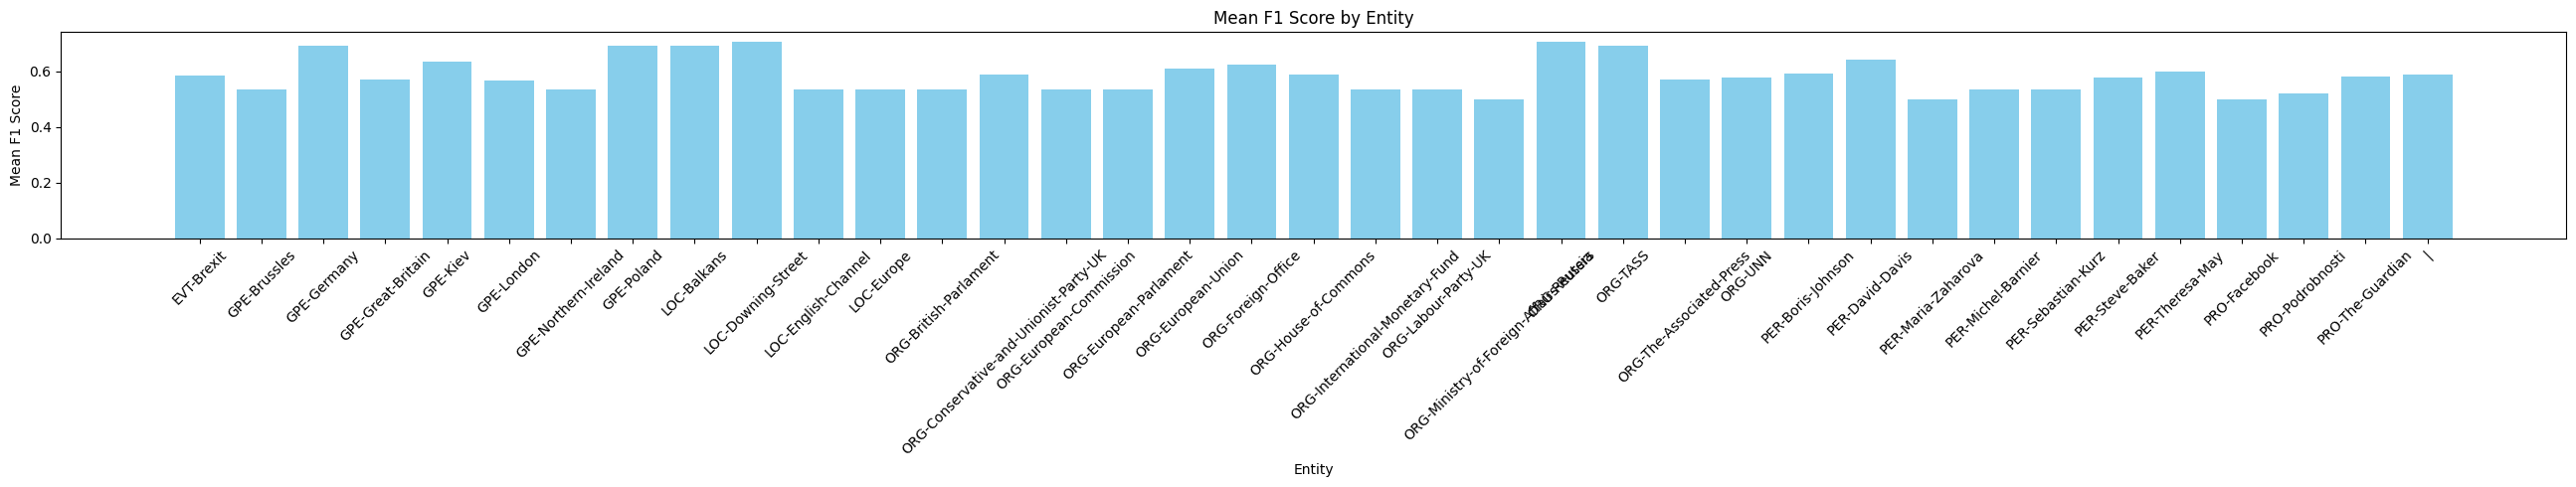

In [7]:
import matplotlib.pyplot as plt

# Изначально уже сагрегировано по документам
# Агрегируем только по сущностям

df_exploded = df.copy()
df_exploded['entity'] = df_exploded['gold_answer'].str.split(' | ')
df_exploded = df_exploded.explode('entity')

agg_results_entity = df_exploded.groupby('entity')['f1_score_no_duplicates'].mean().reset_index()

plt.figure(figsize=(26, 5))
plt.bar(agg_results_entity['entity'], agg_results_entity['f1_score_no_duplicates'], color='skyblue')
plt.xlabel('Entity')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score by Entity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


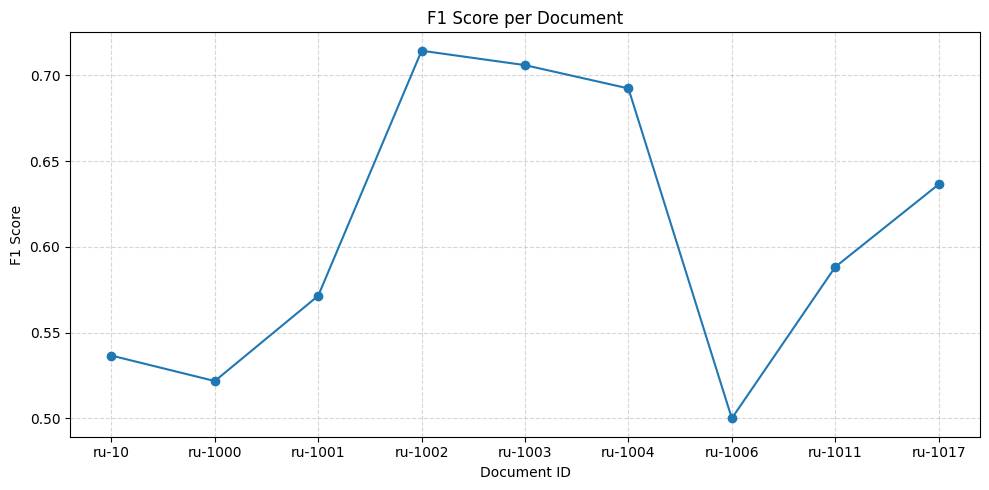

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df['document_id'], df['f1_score_no_duplicates'], marker='o')
plt.xlabel('Document ID')
plt.ylabel('F1 Score')
plt.title('F1 Score per Document')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Можно наблюдать, что скоры действительно разнятся на обоих графиках. Можно сказать следующее

1) Можно сделать вывод, что сущности с длинными названиями выделяются хуже (в среднем): скорее всего, просто было придумано альтернативное название гигачатом.
2) В темах, к которым относятся сущности с плохими скорами, модель разбирается хуже.
3) Можно наблюдать существенную разницу скора между документами. Документы одинаковые по теме (значит, должны быть схожи по выделенным сущностям), значит разница в чем-то другом. Возможно, в длине?

In [9]:
df['doc_len'] = [len(text) for text in df['document_text']]

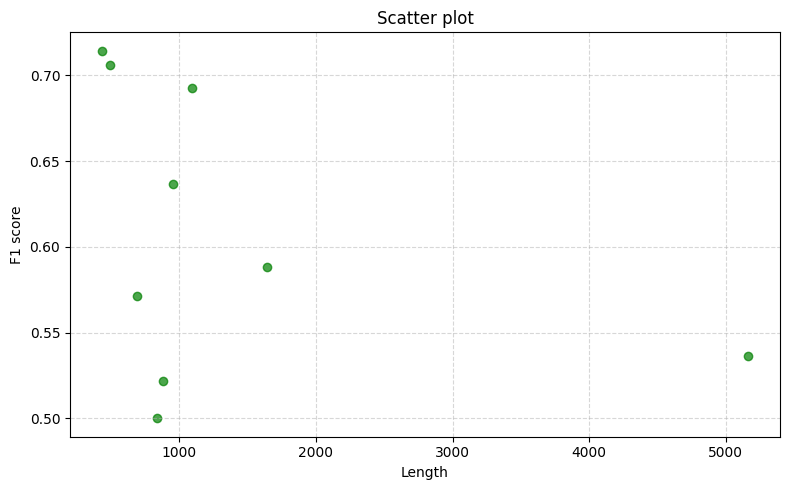

In [10]:
plt.figure(figsize=(8, 5))
plt.scatter(df['doc_len'], df['f1_score_no_duplicates'], alpha=0.7, color='green')
plt.xlabel('Length')
plt.ylabel('F1 score')
plt.title('Scatter plot')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


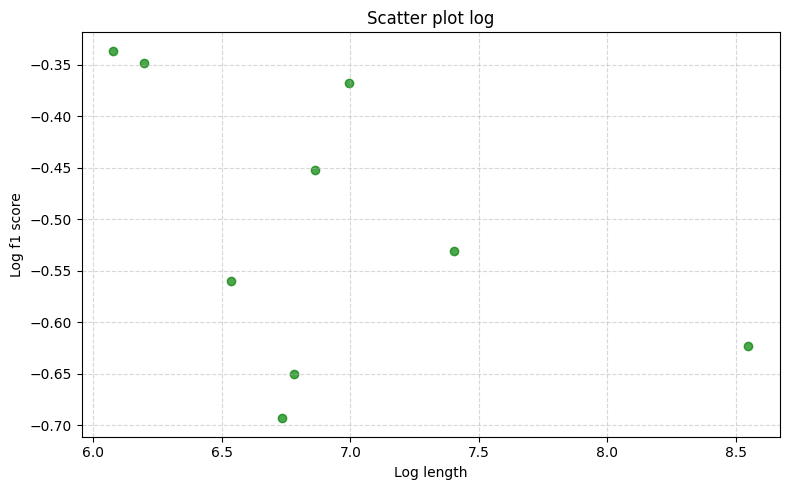

In [11]:
import numpy as np

plt.figure(figsize=(8, 5))
plt.scatter(
    np.log(df['doc_len']),
    np.log(df['f1_score_no_duplicates']),
    alpha=0.7,
    color='green'
)
plt.xlabel('Log length')
plt.ylabel('Log f1 score')
plt.title('Scatter plot log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Можно действительно наблюдать слабую, но все же корреляцию между длиной и f1 скором (особенно если взять логарифм). Чем больше длина документа, тем хуже f1 скор - хотя данных маловато.

**Анализ ошибок**

Можно выделить основные ошибки:

1) Модель иногда неправильно определяет суффикс для gold ответа (хотя тег определен верно) для более длинных сущностей (для коротких хорошо).
2) Модель генерирует сущность лишь единожды. Встретив Джонсона один раз, во второй раз его сущность писать не будет. Это, по идее, неправильное поведение.
3) Неидеальность лэйблов / несовершенность мироздания: непонятно откуда взявшийся тег GPE, а также (субьективно неверно) Guardian был отнесен к продукту, а не к организации (GigaChat отнес к организации). Т.е бывают моменты, когда даже человеку не очень понятно, куда отнести сущность.

Методы исправления:
1) Использовать 2-shot/3-shot. Таким образом, модель лучше проникнется "неидеальностью" данных, и в целом лучше будет себя показывать.
2) Составить более качественный промпт: в частности, чтобы генерировался golden answer для каждого упоминания сущности в тексте.
3) Использовать другой подход: потенциально, специально дообученный BERT (см. самый верх) будет лучше себя показывать.

**Выводы / чему научился**

Самое важное - понял, что существует задача классификации токенов в последовательности, и что NER к ним относится - устранил большой пробел в знаниях. Разобрался, какие методы решения задачи существуют, детально понял как они работают. Что нового попробовал - промпт-инжиниринг, one-shot промпт для решения задачи. Полностью разобрался в метриках для классификации, и как их считать в разных ситуациях.